In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
with open('Pickled_df/wid_spr_mat.pickle','rb') as f:
    wid_spr_mat = pickle.load(f)

In [3]:
with open('Pickled_df/test_df.pickle','rb') as f:
    test_df = pickle.load(f)

In [4]:
test_df.head()

,Image,Im_mat
0,00028a005.jpg,"[[184, 183, 189, 192, 191, 193, 194, 188, 190,..."
1,000dcf7d8.jpg,"[[175, 163, 171, 177, 170, 161, 150, 161, 157,..."
2,000e7c7df.jpg,"[[188, 187, 192, 206, 217, 203, 188, 173, 166,..."
3,0019c34f4.jpg,"[[137, 132, 148, 134, 125, 136, 144, 122, 104,..."
4,001a4d292.jpg,"[[63, 68, 62, 70, 81, 77, 62, 56, 60, 71, 78, ..."


In [5]:
test_df.tail()

,Image,Im_mat
7955,ffe7f4d86.jpg,"[[112, 131, 120, 121, 101, 103, 115, 108, 106,..."
7956,ffe7fcba6.jpg,"[[148, 152, 153, 174, 174, 171, 176, 167, 171,..."
7957,fff504ebd.jpg,"[[236, 236, 236, 236, 234, 234, 236, 239, 240,..."
7958,fffed0665.jpg,"[[215, 219, 217, 216, 219, 217, 216, 220, 218,..."
7959,ffffc6980.jpg,"[[132, 135, 145, 122, 116, 129, 122, 104, 94, ..."


In [6]:
def init_wgts(shape):
    shape = np.array(shape)
    w_vals = tf.truncated_normal(shape=shape.flatten(),stddev=0.1)
    return tf.Variable(w_vals)

In [7]:
def init_bias(shape):
    shape = np.array(shape)
    b_vals = tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(b_vals)

In [8]:
def cov2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")

In [9]:
def maxpool2by2(x):
    return tf.nn.max_pool(x,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

In [10]:
def covlyr(x,shape):
    w = init_wgts([shape])
    b = init_bias([shape[-1]])
    return tf.nn.relu(cov2d(x,w)+b)

In [11]:
def full_clsfr(con_to_full,out_size):
    in_size = int(con_to_full.get_shape()[1])
    w = init_wgts([in_size,out_size])
    b = init_bias([out_size])
    return (tf.matmul(con_to_full,w)+b)

In [12]:
x = tf.placeholder(tf.float32,shape=[None,128,128,1])
y = tf.placeholder(tf.float32,shape=[None,5005])

In [13]:
covlyr_1 = covlyr(x,shape=[4,4,1,32])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
maxpool2by2_1 = maxpool2by2(covlyr_1)

In [15]:
covlyr_2 = covlyr(maxpool2by2_1,shape=[4,4,32,64])

In [16]:
maxpool2by2_2 = maxpool2by2(covlyr_2)

In [17]:
con_to_full = tf.reshape(maxpool2by2_2,shape=[-1,8*8*64])

In [18]:
full_clsfr_1 = full_clsfr(con_to_full,10010)

In [19]:
full_clsfr_1 = tf.nn.relu(full_clsfr_1)

In [20]:
hold_prob = tf.placeholder(tf.float32)
full_out_dropout = tf.nn.dropout(full_clsfr_1,keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
y_pred = full_clsfr(full_out_dropout,5005)

In [22]:
first_5 = tf.nn.top_k(y_pred,k=5)

In [23]:
# we need while creating submission file
p_val = first_5.values
p_ind = first_5.indices

In [24]:
loss_fn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate= 0.0001)

In [26]:
train = optimizer.minimize(loss_fn)

In [27]:
init = tf.global_variables_initializer()

In [28]:
saver = tf.train.Saver()

In [29]:
sess = tf.InteractiveSession()

In [30]:
saver.restore(sess,'CNN_mdl/CNN_prj_wid.ckpt')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from CNN_mdl/CNN_prj_wid.ckpt


In [31]:
type(wid_spr_mat.get_feature_names())

list

In [32]:
[wid_spr_mat.get_feature_names()[i] for i in [15,20,70,2]]

['w_00d50c9', 'w_0115c24', 'w_03a82c1', 'w_0003c59']

In [33]:
wid_spr_mat.get_feature_names()[2]

'w_0003c59'

In [34]:
' '.join([wid_spr_mat.get_feature_names()[i] for i in [15,20,70,2,1]])

'w_00d50c9 w_0115c24 w_03a82c1 w_0003c59 w_0003639'

In [40]:
def pre_id(img):
    img = img.reshape(1,128,128,1)/255
    ind5 = sess.run(p_ind,feed_dict={x:img,hold_prob:1})
    ind = ind5[0,0]
#     print(ind5,ind)
#     return ' '.join([wid_spr_mat.get_feature_names()[i] for i in ind])?
    return wid_spr_mat.get_feature_names()[ind]

In [36]:
sample_df = pd.read_csv('sample_submission.csv')

In [37]:
test_df['Im_mat'][6000]

array([[ 87,  90,  92, ..., 108, 112, 114],
       [ 88,  88,  88, ..., 105, 103, 100],
       [ 88,  86,  84, ..., 107, 105, 101],
       ...,
       [175, 169, 153, ..., 136, 108, 105],
       [162, 163, 156, ..., 124, 134, 135],
       [172, 177, 178, ..., 132, 133, 145]], dtype=uint8)

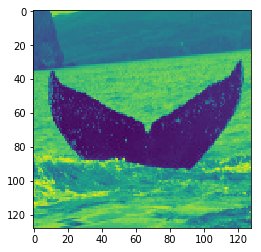

In [38]:
plt.imshow(test_df['Im_mat'][6000])

In [41]:
pre_id(test_df['Im_mat'][6000])

'w_c0d11da'

In [42]:
sample_df['Id'][0]

'new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c'

In [43]:
test_df['Id'] = test_df['Im_mat'].apply(pre_id)

In [44]:
# with open('Pickled_df/test_df_with_pred.pickle','wb') as f:
#     pickle.dump(test_df,f)

In [45]:
test_sub = test_df.drop('Im_mat',axis=1)

In [46]:
test_sub['Id'][4]

'new_whale'

In [47]:
sample_df['Id'][4]

'new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c'

In [48]:
test_sub.to_csv('test_submit_1.0.csv',index=False)

In [49]:
sess.close()

Lets submit 

<t>
<tr><td>Private Score</td><td>Public Score</td></tr>
<tr><td>0.31868</td><td>0.30058</td></tr>
</t>